# Setup

In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Keras Image Data Generator

In [ ]:
!git clone https://github.com/cvjena/labelmefacade.git

# Make the dataset readible by DataGen
!mkdir -p facade_dataset/train_images/train
!mkdir -p facade_dataset/train_masks/train

!cp labelmefacade/images/* facade_dataset/train_images/train/
!cp labelmefacade/labels/* facade_dataset/train_masks/train/

Cloning into 'labelmefacade'...
remote: Enumerating objects: 1907, done.
remote: Total 1907 (delta 0), reused 0 (delta 0), pack-reused 1907
Receiving objects: 100% (1907/1907), 102.18 MiB | 48.67 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rescale = 1/255.,
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=False,
                      fill_mode='reflect')

mask_data_gen_args = dict(rescale = 1/255.,
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=False,
                      fill_mode='reflect',
                      )

seed=24
batch_size= 8

root_directory = '/content/facade_dataset'
train_images_path = f'{root_directory}/train_images'
train_masks_path = f'{root_directory}/train_masks'

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(train_images_path,
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(train_masks_path,
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         class_mode=None)

Found 945 images belonging to 1 classes.
Found 945 images belonging to 1 classes.


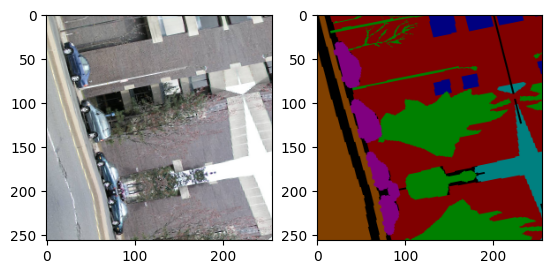

In [ ]:
x = image_generator.next()
y = mask_generator.next()

for i in range(0, 1):
    image = x[i]
    mask = y[i]

    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask)
    plt.show()

# Dataset Loading & Preprocessing

In [ ]:
!pip install patchify

In [ ]:
!git clone https://github.com/cvjena/labelmefacade.git

# Swap the train and test files
!mv /content/labelmefacade/test.txt /content/labelmefacade/temp.txt
!mv /content/labelmefacade/train.txt /content/labelmefacade/test.txt
!mv /content/labelmefacade/temp.txt /content/labelmefacade/train.txt

Cloning into 'labelmefacade'...
remote: Enumerating objects: 1907, done.
remote: Total 1907 (delta 0), reused 0 (delta 0), pack-reused 1907
Receiving objects: 100% (1907/1907), 102.18 MiB | 14.70 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify

def read_filenames(txt_path):
    with open(txt_path, 'r') as file:
        filenames = [line.strip().replace('images/', '').rsplit('.', 1)[0] for line in file if line.strip()]
    return filenames

def save_patches(patches, directory, base_filename, ext=".png"):
    os.makedirs(directory, exist_ok=True)
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i, j, 0]  # Drop the extra unnecessary dimension
            patch_filename = f"{base_filename}_patch_{i}_{j}{ext}"
            patch_path = os.path.join(directory, patch_filename)
            cv2.imwrite(patch_path, patch)

def patchify_images_and_masks(filenames, root_directory, patch_size, saved_images_path, saved_masks_path):
    image_dir = os.path.join(root_directory, "images")
    mask_dir = os.path.join(root_directory, "labels")

    for filename in filenames:
        image_path = os.path.join(image_dir, f"{filename}.jpg")
        mask_path = os.path.join(mask_dir, f"{filename}.png")

        if os.path.exists(image_path) and os.path.exists(mask_path):
            # Read and resize the image
            image = cv2.imread(image_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_COLOR)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

            # Ensure the image and mask are the same size
            min_size_x = min(image.shape[1], mask.shape[1])
            min_size_y = min(image.shape[0], mask.shape[0])
            SIZE_X = (min_size_x // patch_size) * patch_size
            SIZE_Y = (min_size_y // patch_size) * patch_size

            # Crop the images to the nearest size divisible by patch_size
            image = Image.fromarray(image).crop((0, 0, SIZE_X, SIZE_Y))
            image = np.array(image)
            mask = Image.fromarray(mask).crop((0, 0, SIZE_X, SIZE_Y))
            mask = np.array(mask)

            # Patchify the images and masks
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

            # Save the patches
            save_patches(patches_img, saved_images_path, filename)
            save_patches(patches_mask, saved_masks_path, filename)

In [ ]:
out_dir = '/content/drive/MyDrive/facade-semantic-seg'

train_filenames = read_filenames('/content/labelmefacade/train.txt')
test_filenames = read_filenames('/content/labelmefacade/test.txt')

patchify_images_and_masks(train_filenames, '/content/labelmefacade', 256, f'{out_dir}/train/images', f'{out_dir}/train/masks')
patchify_images_and_masks(test_filenames, '/content/labelmefacade', 256, f'{out_dir}/test/images', f'{out_dir}/test/masks')

In [ ]:
!ls -1 /content/drive/MyDrive/facade-semantic-seg/train/images | wc -l
!ls -1 /content/drive/MyDrive/facade-semantic-seg/test/images | wc -l
!ls -1 /content/drive/MyDrive/facade-semantic-seg/train/masks | wc -l
!ls -1 /content/drive/MyDrive/facade-semantic-seg/test/masks | wc -l

3408
404
3408
404


# Training

## Custom Data Generator

In [2]:
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical


def rgb_to_labels(rgb_image, class_colors):
    labels_image = np.zeros(rgb_image.shape[:2], dtype=np.uint8)
    for rgb, label in class_colors.items():
        mask = np.all(rgb_image == np.array(rgb), axis=-1)
        labels_image[mask] = label
    return labels_image

# Define the preprocessing function for the generator
def preprocess_mask(mask, n_classes):
    # Convert RGB mask to labels
    labels = rgb_to_labels(mask, class_colors)
    # Convert labels to categorical
    labels_cat = to_categorical(labels, num_classes=n_classes, dtype=np.uint8)
    return labels_cat

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir, class_colors, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_colors = class_colors
        self.image_filenames = [image_name for image_name in sorted(os.listdir(image_dir)) if image_name.endswith(".png")] # jpg
        self.mask_filenames = [mask_name for mask_name in sorted(os.listdir(mask_dir)) if mask_name.endswith(".png")]  # png
        self.indexes = np.arange(len(self.image_filenames))
        self.shuffle = shuffle
        self.n_classes = len(class_colors) + 1

    def __len__(self):
        return len(self.image_filenames) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = []
        batch_masks = []

        for idx in batch_indexes:
            image_filename = self.image_filenames[idx]
            mask_filename = self.mask_filenames[idx]

            image_path = os.path.join(self.image_dir, image_filename)
            mask_path = os.path.join(self.mask_dir, mask_filename)

            image = cv2.imread(image_path, 1)
            image = Image.fromarray(image)
            image = np.array(image)

            mask = cv2.imread(mask_path, 1)
            mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
            mask = Image.fromarray(mask)
            mask = np.array(mask)

            batch_images.append(image)
            batch_masks.append(mask)

        # TODO: Use preprocess_mask function
        labels = np.array([rgb_to_labels(mask, class_colors) for mask in batch_masks])
        batch_masks_cat = to_categorical(labels, num_classes=self.n_classes)

        return np.array(batch_images), np.array(batch_masks_cat)

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

## U-Net Architecture

In [3]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization, Activation
from keras import backend as K

def jaccard_coef(y_true, y_pred):
    """Calculate the Jaccard coefficient, a similarity measure for semantic segmentation."""
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + 1.0) / (union + 1.0)

def conv2d_block(input_tensor, num_filters, kernel_size=3, batch_norm=True, dropout=0.2):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(num_filters, (kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(num_filters, (kernel_size, kernel_size), kernel_initializer='he_normal', padding='same')(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if dropout > 0:
        x = Dropout(dropout)(x)

    return x

def multi_unet_model(n_classes, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    # Contraction path
    c1 = conv2d_block(inputs, 16, batch_norm=True, dropout=0.1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = conv2d_block(p1, 32, batch_norm=True, dropout=0.1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = conv2d_block(p2, 64, batch_norm=True, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = conv2d_block(p3, 128, batch_norm=True, dropout=0.2)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = conv2d_block(p4, 256, batch_norm=True, dropout=0.3)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv2d_block(u6, 128, batch_norm=True, dropout=0.2)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv2d_block(u7, 64, batch_norm=True, dropout=0.2)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv2d_block(u8, 32, batch_norm=True, dropout=0.1)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv2d_block(u9, 16, batch_norm=True, dropout=0.1)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
    model = Model(inputs=[inputs], outputs=[outputs], name='U-Net')

    return model

## Training

In [4]:
DATASET_HOME = '/content/drive/MyDrive/facade-semantic-seg'
DATASET_TRAIN = f'{DATASET_HOME}/train'
DATASET_TEST = f'{DATASET_HOME}/test'

train_images_path = f'{DATASET_TRAIN}/images'
train_masks_path = f'{DATASET_TRAIN}/masks'
val_images_path = f'{DATASET_TEST}/images'
val_masks_path = f'{DATASET_TEST}/masks'

# Define RGB values for each class
class_colors = {
    (0, 0, 0): 0,        # various
    (128, 0, 0): 1,      # building
    (128, 0, 128): 2,    # car
    (128, 128, 0): 3,    # door
    (128, 128, 128): 4,  # pavement
    (128, 64, 0): 5,     # road
    (0, 128, 128): 6,    # sky
    (0, 128, 0): 7,      # vegetation
    (0, 0, 128): 8       # window
}

batch_size = 8
n_classes = len(class_colors) + 1

train_generator = CustomDataGenerator(image_dir=train_images_path,
                                      mask_dir=train_masks_path,
                                      batch_size=batch_size,
                                      class_colors=class_colors)

train_steps = train_generator.__len__()
print(f'train_steps: {train_steps}')


val_generator = CustomDataGenerator(image_dir=val_images_path,
                                      mask_dir=val_masks_path,
                                      batch_size=batch_size,
                                      class_colors=class_colors)

val_steps = val_generator.__len__()
print(f'val_steps: {val_steps}')

train_steps: 426
val_steps: 50


In [5]:
img, mask = train_generator.__getitem__(0)

IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = img[0].shape
n_classes = mask.shape[-1]

print(f'image shape: {img[0].shape}')
print(f'number of classes: {n_classes}')

image shape: (256, 256, 3)
number of classes: 10


In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau # TensorBoard, CSVLogger

def get_callbacks(model_name='top-weights.keras'):
    # ModelCheckpoint: Save the best model based on validation accuracy
    mc = ModelCheckpoint(
        filepath=model_name,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    # EarlyStopping: Stop training if validation accuracy stops improving
    es = EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        verbose=0
    )

    # ReduceLROnPlateau: Reduce learning rate if validation accuracy stops improving
    rl = ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.1,
        patience=5,
        verbose=1,
        mode="max",
        min_lr=0.0001
    )

    return [mc, es, rl]

In [10]:
model = multi_unet_model(
        n_classes=n_classes,
        IMG_HEIGHT=IMG_HEIGHT,
        IMG_WIDTH=IMG_WIDTH,
        IMG_CHANNELS=IMG_CHANNELS)

metrics=['accuracy', jaccard_coef]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_19 (Conv2D)          (None, 256, 256, 16)         448       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_18 (Ba  (None, 256, 256, 16)         64        ['conv2d_19[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_18 (Activation)  (None, 256, 256, 16)         0         ['batch_normalization_18[0

In [11]:
callbacks = get_callbacks()

history = model.fit(train_generator,
                    steps_per_epoch=train_steps,
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=val_steps,
                    callbacks=callbacks)

Epoch 1/30
426/426 [==============================] - ETA: 0s - loss: 1.4987 - accuracy: 0.5637 - jaccard_coef: 0.2120
Epoch 1: val_accuracy improved from -inf to 0.66378, saving model to top-weights.h5
426/426 [==============================] - 126s 270ms/step - loss: 1.4987 - accuracy: 0.5637 - jaccard_coef: 0.2120 - val_loss: 1.0660 - val_accuracy: 0.6638 - val_jaccard_coef: 0.3534 - lr: 0.0010
Epoch 2/30
426/426 [==============================] - ETA: 0s - loss: 1.0859 - accuracy: 0.6655 - jaccard_coef: 0.3352
Epoch 2: val_accuracy improved from 0.66378 to 0.72373, saving model to top-weights.h5
426/426 [==============================] - 116s 273ms/step - loss: 1.0859 - accuracy: 0.6655 - jaccard_coef: 0.3352 - val_loss: 0.8991 - val_accuracy: 0.7237 - val_jaccard_coef: 0.3712 - lr: 0.0010
Epoch 3/30
426/426 [==============================] - ETA: 0s - loss: 0.9981 - accuracy: 0.6888 - jaccard_coef: 0.3671
Epoch 3: val_accuracy improved from 0.72373 to 0.75254, saving model to top-

In [14]:
model.save('unet_model.keras')

# Testing

In [15]:
import numpy as np

def labels_to_rgb(labels, inverse_class_colors):
    rgb_image = np.zeros((labels.shape[0], labels.shape[1], 3), dtype=np.uint8)
    for label, rgb in inverse_class_colors.items():
        rgb_image[labels == label] = rgb
    return rgb_image

def postprocess_mask(labels_cat, inverse_class_colors):
    # Convert categorical labels back to integer labels
    labels = np.argmax(labels_cat, axis=-1)
    # Convert integer labels to RGB mask
    mask_rgb = labels_to_rgb(labels, inverse_class_colors)
    return mask_rgb


# Invert the class_colors dictionary to map integer labels back to RGB colors
inverse_class_colors = {v: k for k, v in class_colors.items()}

In [86]:
images, masks = val_generator.__getitem__(2)

predictions = model.predict(images)

1/1 [==============================] - 0s 27ms/step


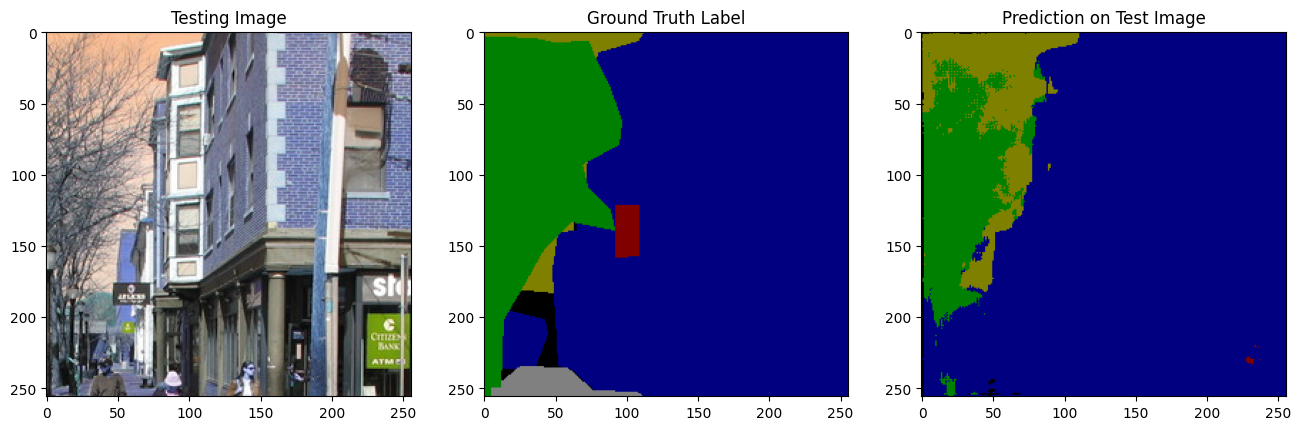

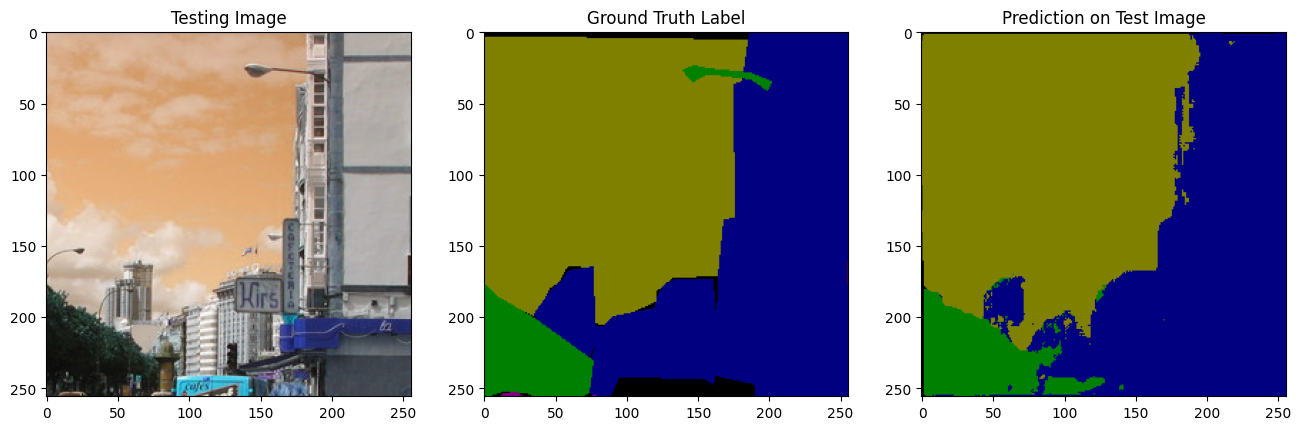

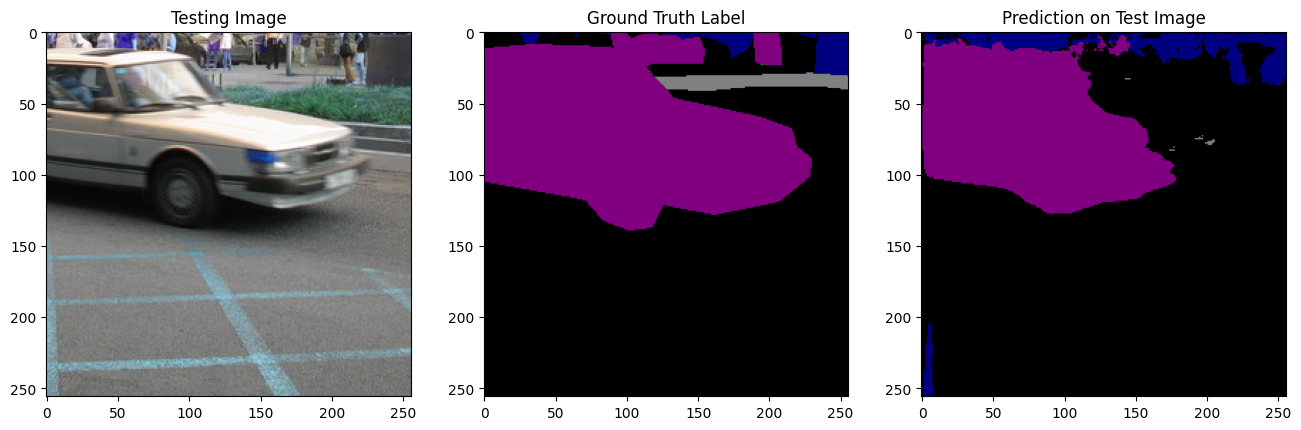

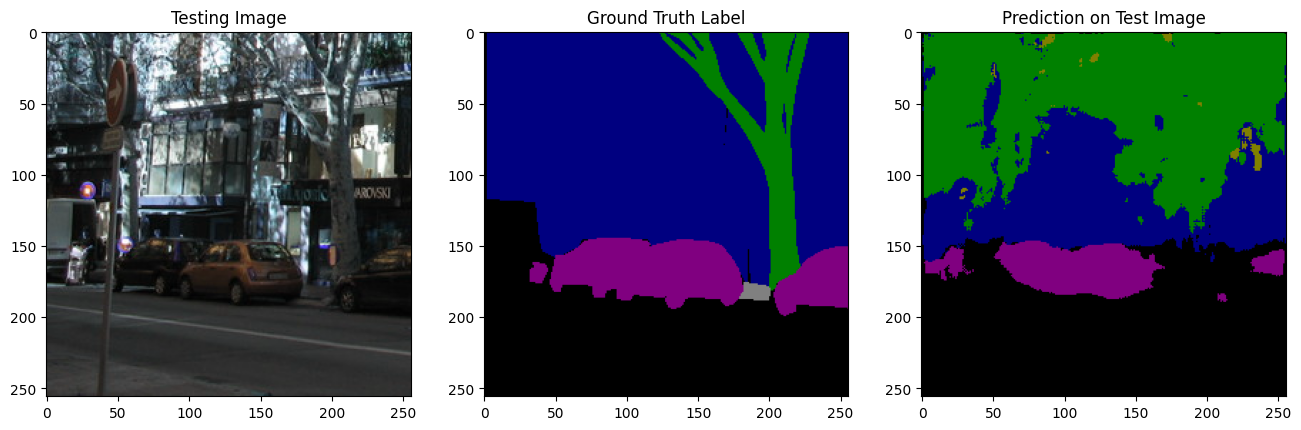

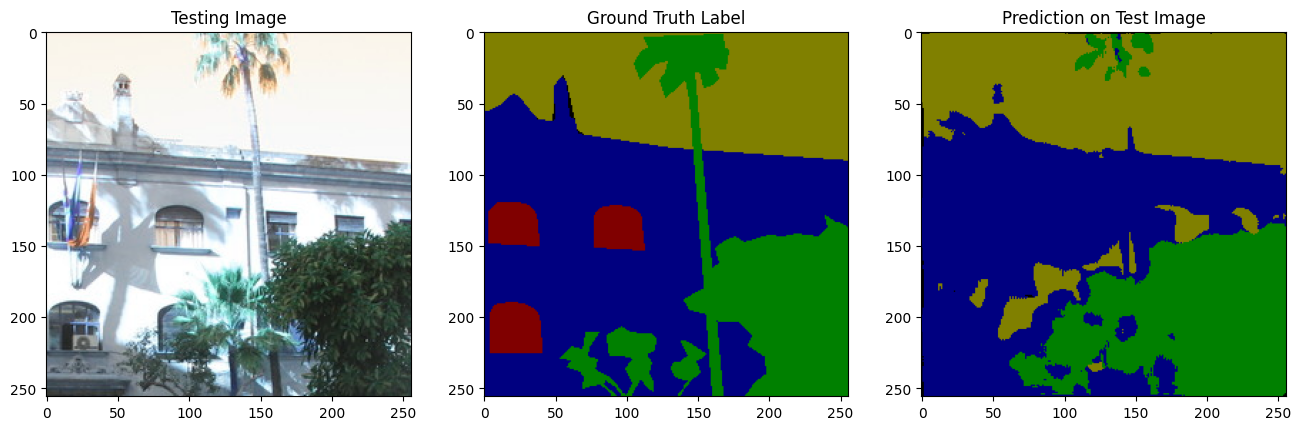

In [87]:
import random
import matplotlib.pyplot as plt

num_samples = 5

# Generate random indexes without replacement
indexes = np.random.choice(images.shape[0], num_samples, replace=False)

for i in indexes:
    test_img = images[i]
    ground_truth = postprocess_mask(masks[i], inverse_class_colors)
    prediction = postprocess_mask(predictions[i], inverse_class_colors)

    plt.figure(figsize=(16, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(132)
    plt.title('Ground Truth Label')
    plt.imshow(ground_truth)
    plt.subplot(133)
    plt.title('Prediction on Test Image')
    plt.imshow(prediction)

    plt.show()

In [67]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects

Git LFS initialized.
Cloning into 'architects'...
remote: Enumerating objects: 2017, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 2017 (delta 3), reused 2 (delta 2), pack-reused 1987 (from 1)
Receiving objects: 100% (2017/2017), 283.15 KiB | 2.34 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Filtering content: 100% (2031/2031), 784.80 MiB | 10.71 MiB/s, done.


In [75]:
import os
import cv2
import numpy as np

def read_test_images(directory_path, target_size=(256, 256)):
    test_images = []
    for root, dirs, files in os.walk(directory_path):
        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_path = os.path.join(root, filename)
                image = cv2.imread(image_path)
                if image is not None:
                    # Resize the image to the target size
                    image = cv2.resize(image, target_size)
                    test_images.append(image)
                else:
                    print(f"Unable to read image: {image_path}")
    return np.array(test_images)

In [81]:
test_images_directory = "/content/architects/well-knowns"

test_images = read_test_images(test_images_directory, target_size=(512, 512))
print(f"Number of test images: {len(test_images)}")
print(f"Shape of test images array: {test_images.shape}")

predictions = model.predict(test_images)

Number of test images: 14
Shape of test images array: (14, 512, 512, 3)
1/1 [==============================] - 7s 7s/step


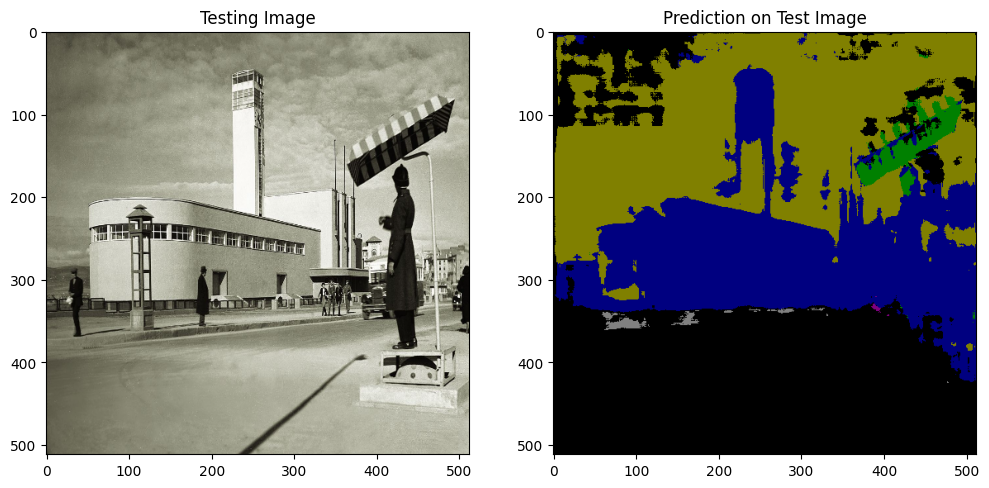

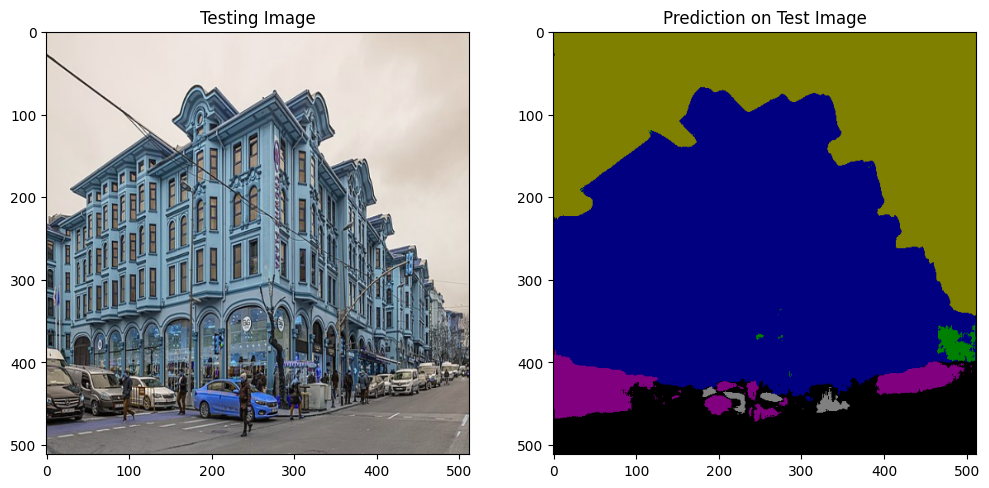

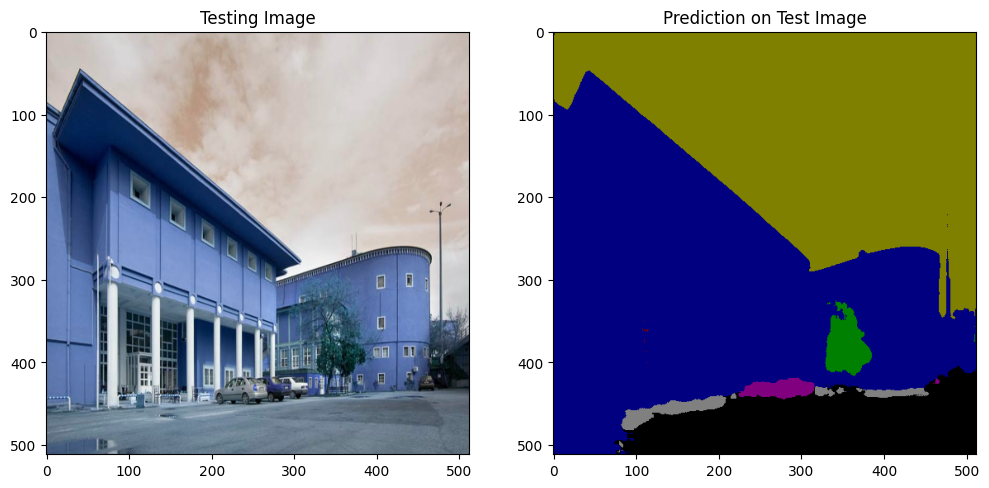

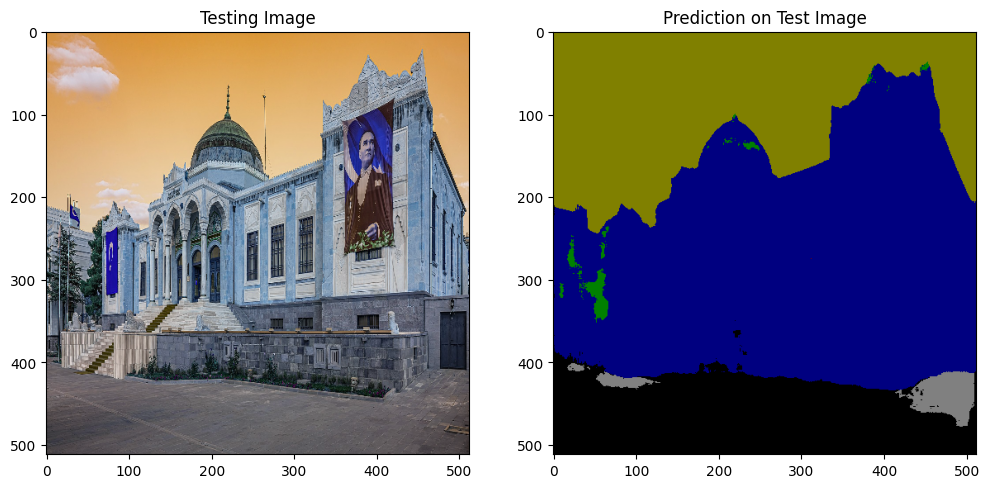

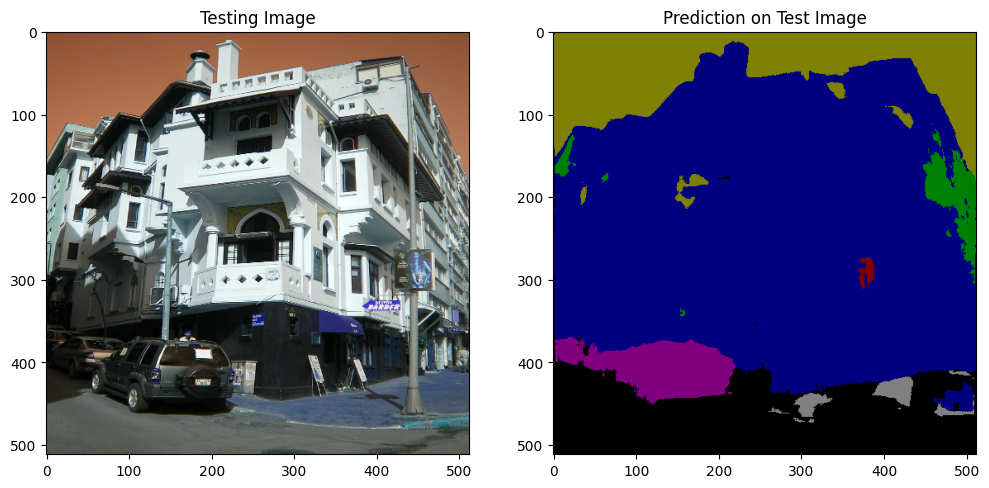

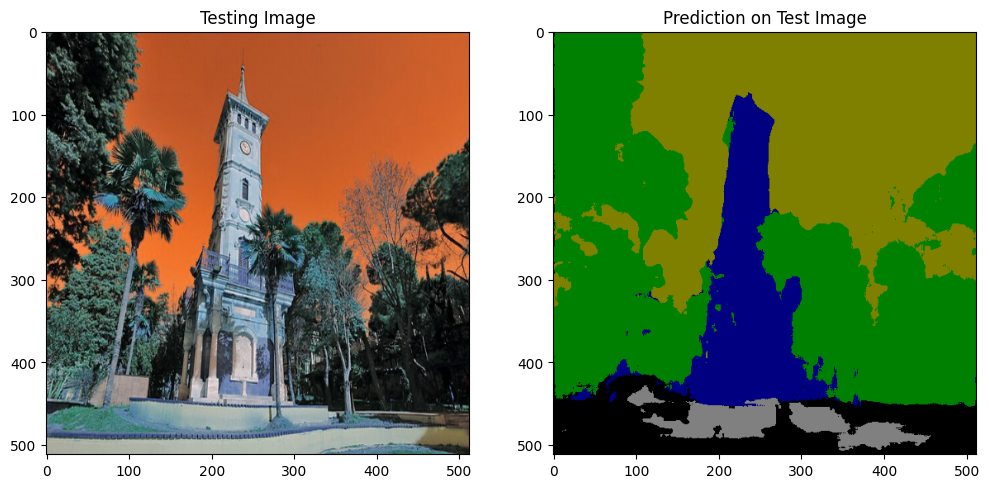

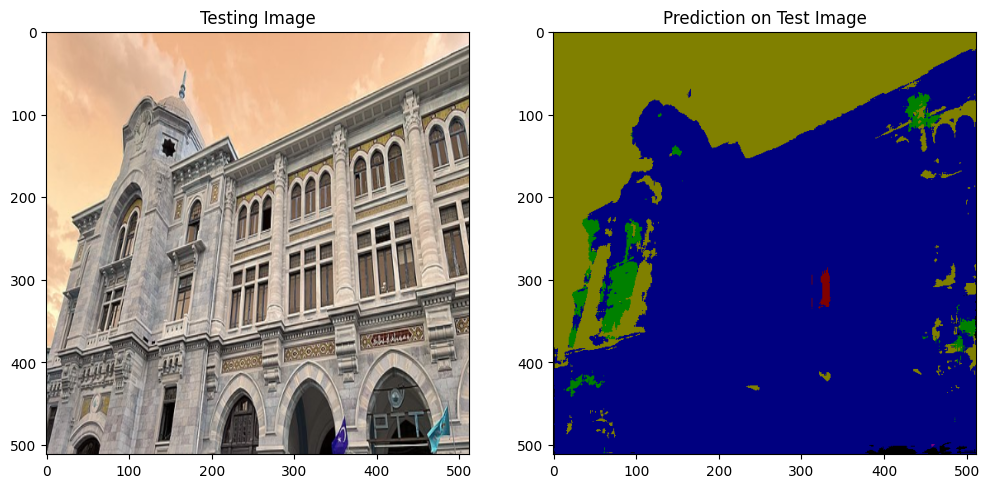

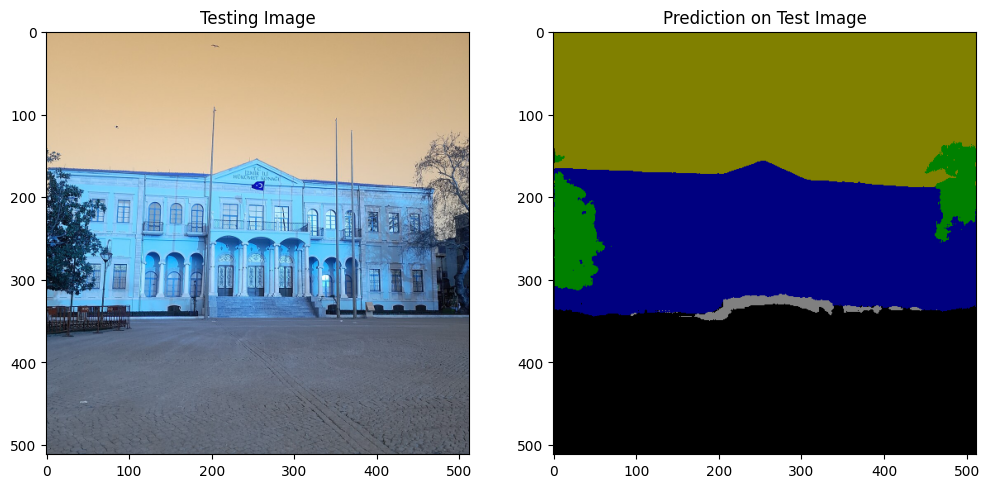

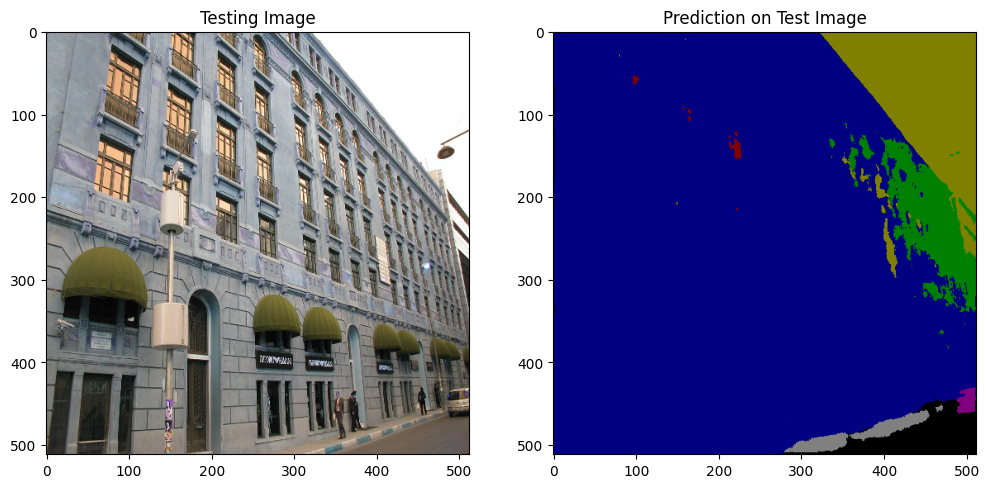

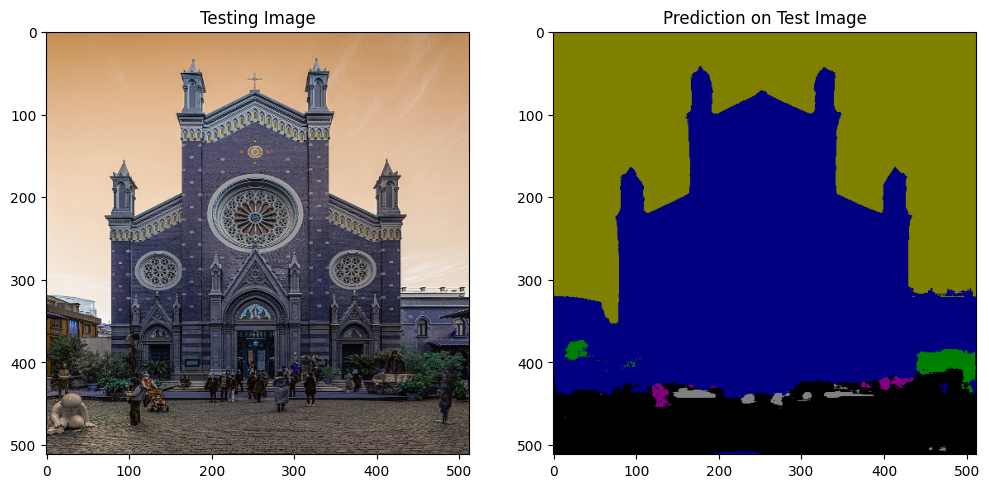

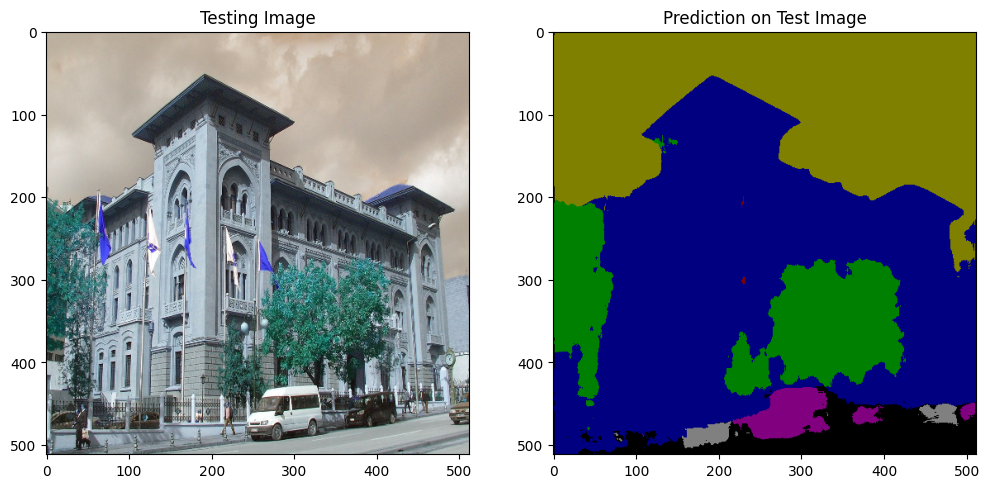

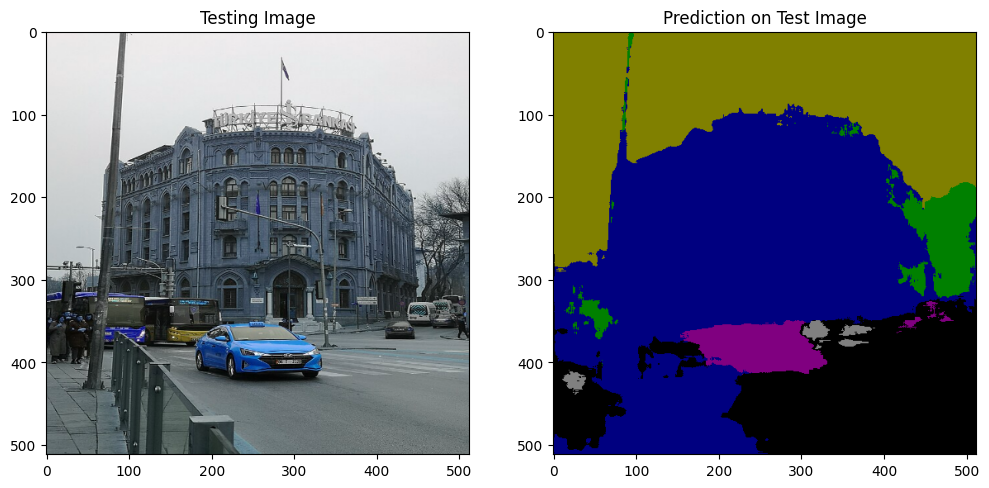

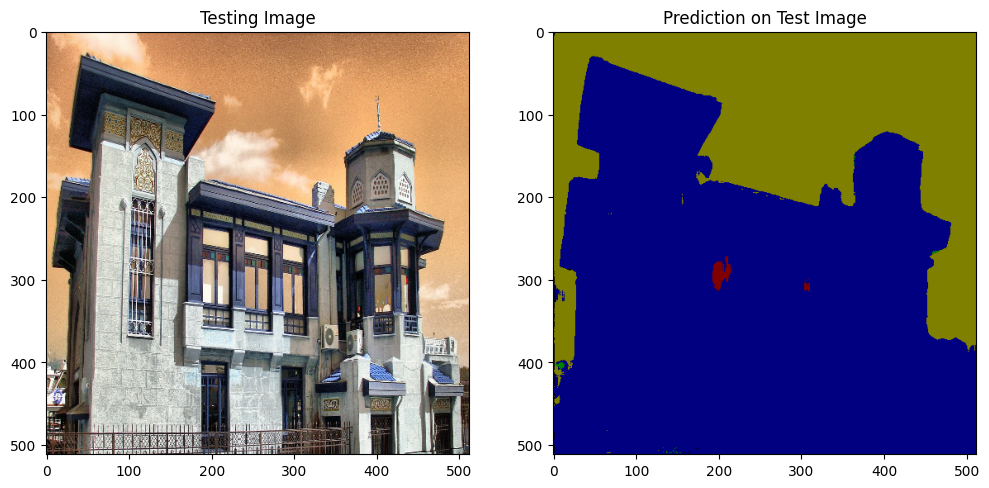

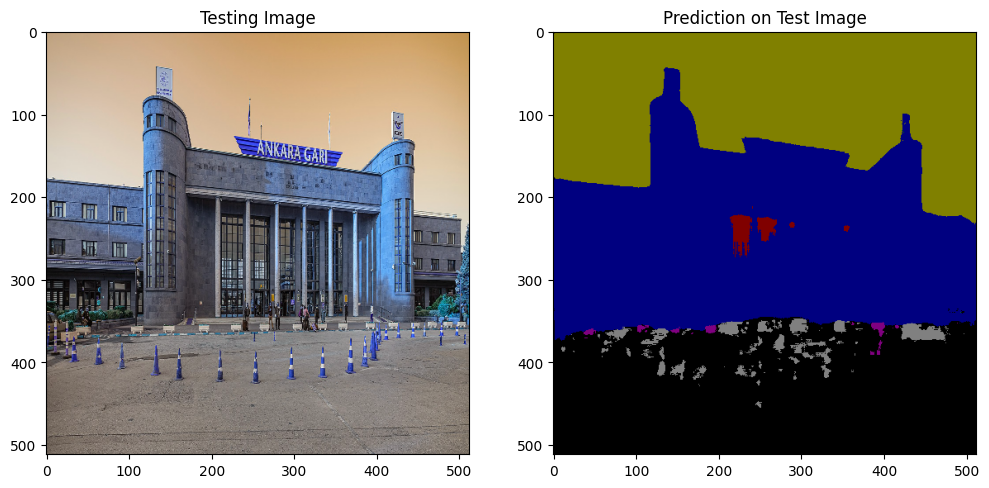

In [84]:
import matplotlib.pyplot as plt

for test_img, prediction in zip(test_images, predictions):
    ground_truth = postprocess_mask(test_img, inverse_class_colors)
    prediction = postprocess_mask(prediction, inverse_class_colors)

    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(122)
    plt.title('Prediction on Test Image')
    plt.imshow(prediction)

    plt.show()

# Feature Extraction Module

# Draft

1/1 [==============================] - 2s 2s/step


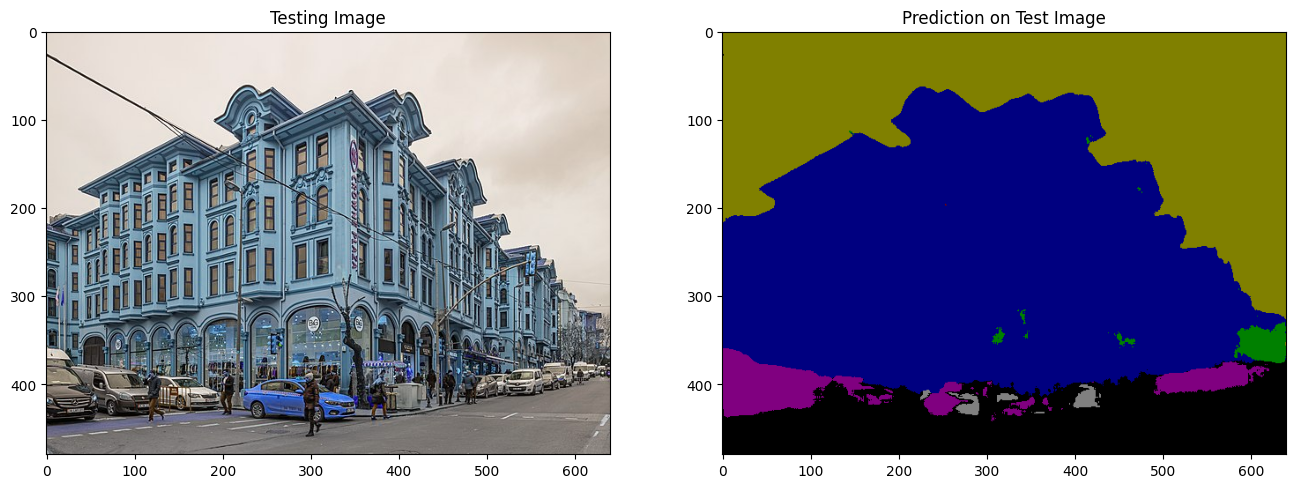

In [94]:
import cv2

def read_img(image_path):
    # patch_size = 256
    image = cv2.imread(image_path, 1)
    # SIZE_X = (image.shape[1] // patch_size) * patch_size
    # SIZE_Y = (image.shape[0] // patch_size) * patch_size
    image = Image.fromarray(image)
    # image = image.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
    return np.array(image)


image_path = '/content/architects/well-knowns/Mimar Kemalettin/Istanbul_asv2020-02_img05_Crowne_Plaza_Old_City.jpg'

# Load the image
test_image = read_img(image_path)
test_image_exp = np.expand_dims(test_image, 0)
predictions = model.predict(test_image_exp)
prediction = postprocess_mask(predictions[0], inverse_class_colors)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Testing Image')
plt.imshow(test_image)
plt.subplot(122)
plt.title('Prediction on Test Image')
plt.imshow(prediction)

plt.show()